In [9]:
from math import log
import scipy.stats as stats
import numpy as np
from numpy import shape
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import animation
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [10]:
class BsmModel:

    def __init__(self, option_type, price, strike, interest_rate, expiry, volatility, dividend_yield=0):
        self.s = price  # Underlying asset price
        self.k = strike  # Option strike K
        self.r = interest_rate  # Continuous risk fee rate
        self.q = dividend_yield  # Dividend continuous rate
        self.T = expiry  # time to expiry (year)
        self.sigma = volatility  # Underlying volatility
        self.type = option_type # option type "p" put option "c" call option

    def n(self, d):
        # cumulative probability distribution function of standard normal distribution
        return stats.norm.cdf(d)

    def dn(self, d):
        # the first order derivative of n(d)
        return stats.norm.pdf(d)

    def d1(self):
        d1 = (log(self.s / self.k) + (self.r - self.q + self.sigma ** 2 * 0.5) * self.T) / (self.sigma * sqrt(self.T))
        return d1

    def d2(self):
        d2 = (log(self.s / self.k) + (self.r - self.q - self.sigma ** 2 * 0.5) * self.T) / (self.sigma * sqrt(self.T))
        return d2

    def bsm_price(self):
        d1 = self.d1()
        d2 = d1 - self.sigma * sqrt(self.T)
        if self.type == 'c':
            price = exp(-self.r*self.T) * (self.s * exp((self.r - self.q)*self.T) * self.n(d1) - self.k * self.n(d2))
            return price
        elif self.type == 'p':
            price = exp(-self.r*self.T) * (self.k * self.n(-d2) - (self.s * exp((self.r - self.q)*self.T) * self.n(-d1)))
            return price
        else:
            print "option type can only be c or p"

    ''' Greek letters for European options on an asset that provides a yield at rate q '''

    def delta(self):
        d1 = self.d1()
        if self.type == "c":
            return exp(-self.q * self.T) * self.n(d1)
        elif self.type == "p":
            return exp(-self.q * self.T) * (self.n(d1)-1)

    def gamma(self, ):
        d1 = self.d1()
        dn1 = self.dn(d1)
        return dn1 * exp(-self.q * self.T) / (self.s * self.sigma * sqrt(self.T))

    def theta(self):
        d1 = self.d1()
        d2 = d1 - self.sigma * sqrt(self.T)
        dn1 = self.dn(d1)

        if self.type == "c":
            theta = -self.s * dn1 * self.sigma * exp(-self.q*self.T) / (2 * sqrt(self.T)) \
                    + self.q * self.s * self.n(d1) * exp(-self.q*self.T) \
                    - self.r * self.k * exp(-self.r*self.T) * self.n(d2)
            return theta
        elif self.type == "p":
            theta = -self.s * dn1 * self.sigma * exp(-self.q * self.T) / (2 * sqrt(self.T)) \
                    - self.q * self.s * self.n(-d1) * exp(-self.q * self.T) \
                    + self.r * self.k * exp(-self.r * self.T) * self.n(-d2)
            return theta

    def vega(self):
        d1 = self.d1()
        dn1 = self.dn(d1)
        return self.s * sqrt(self.T) * dn1 * exp(-self.q * self.T)

    def rho(self):
        d2 = self.d2()
        if self.type == "c":
            rho = self.k * self.T * (exp(-self.r*self.T)) * self.n(d2)
        elif self.type == "p":
            rho = -self.k * self.T * (exp(-self.r*self.T)) * self.n(-d2)

        return rho

In [11]:
s = np.array([range(10,70,1) for i in range(23)])
I = np.ones((shape(s)))
time = np.arange(1,12.5,0.5)/12
T = np.array([ele for ele in time for i in range(shape(s)[1])]).reshape(shape(s))

In [12]:
contracts = []
for i in range(shape(s)[0]):
    for j in range(shape(s)[1]):
        contracts.append(BsmModel('c',s[i,j],40*I[i,j],0.1*I[i,j], T[i,j],0.5*I[i,j]))
theta = [x.theta() for x in contracts]  
gamma = [x.gamma() for x in contracts]  
delta = [x.delta() for x in contracts]  
vega = [x.vega() for x in contracts]  
rho = [x.rho() for x in contracts]  

In [13]:
gamma = np.array(gamma).reshape(shape(s))
delta = np.array(delta).reshape(shape(s))
theta = np.array(theta).reshape(shape(s))
vega = np.array(vega).reshape(shape(s))
rho = np.array(rho).reshape(shape(s))

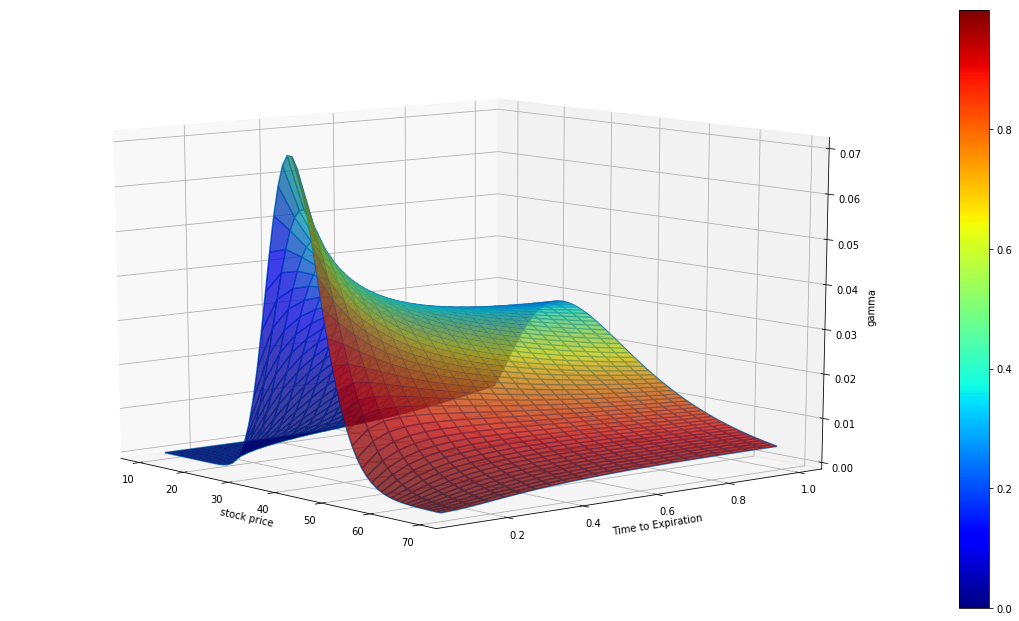

In [19]:
z = gamma
fig = plt.figure(figsize=(20,11))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(12,320)
ax.plot_wireframe(s, T, z, rstride=1, cstride=1)
ax.plot_surface(s, T, z, facecolors=cm.jet(delta),linewidth=0.001, rstride=1, cstride=1, alpha = 0.75)
ax.set_zlim3d(0, z.max())
ax.set_xlabel('stock price')
ax.set_ylabel('Time to Expiration')
ax.set_zlabel('gamma')
m = cm.ScalarMappable(cmap=cm.jet)
m.set_array(delta)
cbar = plt.colorbar(m)

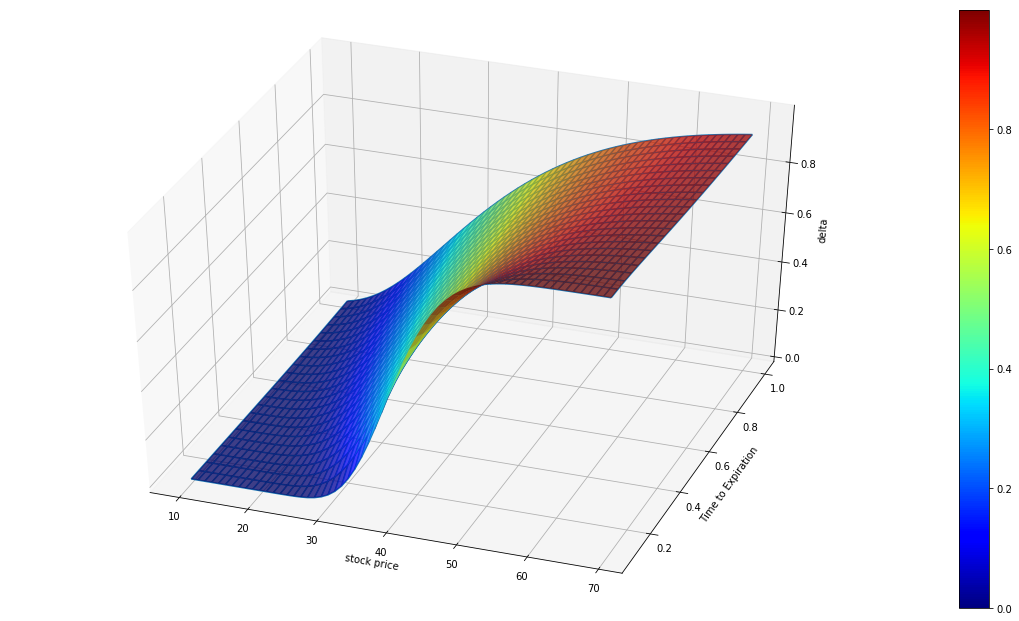

In [20]:
z = delta
fig = plt.figure(figsize=(20,11))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(40,290)
ax.plot_wireframe(s, T, z, rstride=1, cstride=1)
ax.plot_surface(s, T, z, facecolors=cm.jet(delta),linewidth=0.001, rstride=1, cstride=1, alpha = 0.75)
ax.set_zlim3d(0, z.max())
ax.set_xlabel('stock price')
ax.set_ylabel('Time to Expiration')
ax.set_zlabel('delta')
m = cm.ScalarMappable(cmap=cm.jet)
m.set_array(z)
cbar = plt.colorbar(m)

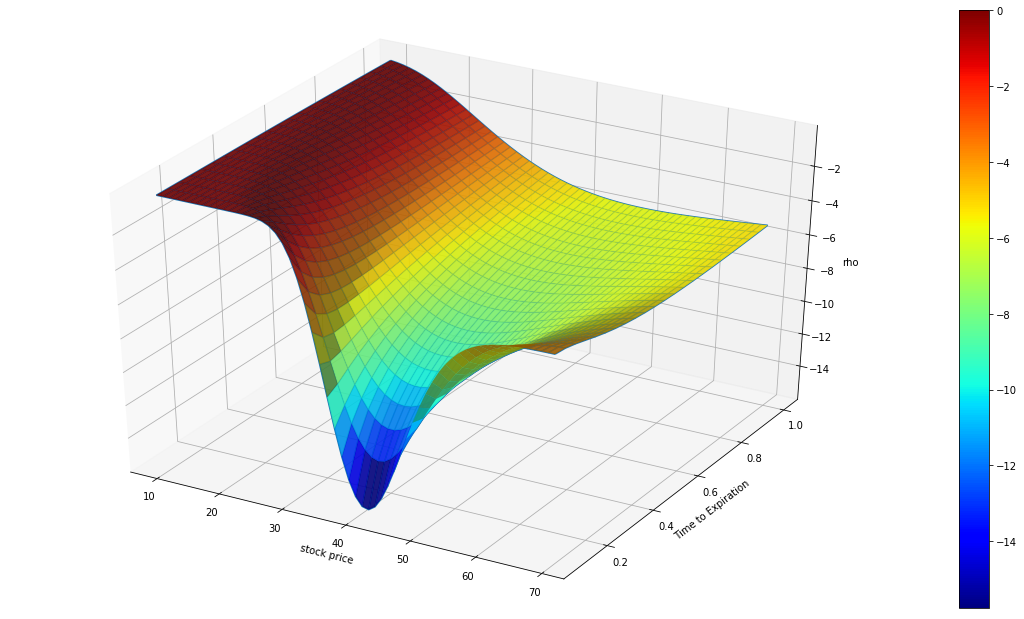

In [21]:
z = theta
# facecolors aren't normalizing as might be expected
# we need to normalize it to avoid all dark color for value under 0
norm = matplotlib.colors.Normalize() 
fig = plt.figure(figsize=(20,11))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(35,300)
ax.plot_wireframe(s, T, z, rstride=1, cstride=1)
ax.plot_surface(s, T, z, facecolors=cm.jet(norm(z)),linewidth=0.001, rstride=1, cstride=1, alpha = 0.9)
ax.set_zlim3d(z.min(), z.max())
ax.set_xlabel('stock price')
ax.set_ylabel('Time to Expiration')
ax.set_zlabel('rho')
m = cm.ScalarMappable(cmap=cm.jet)
m.set_array(z)
cbar = plt.colorbar(m)

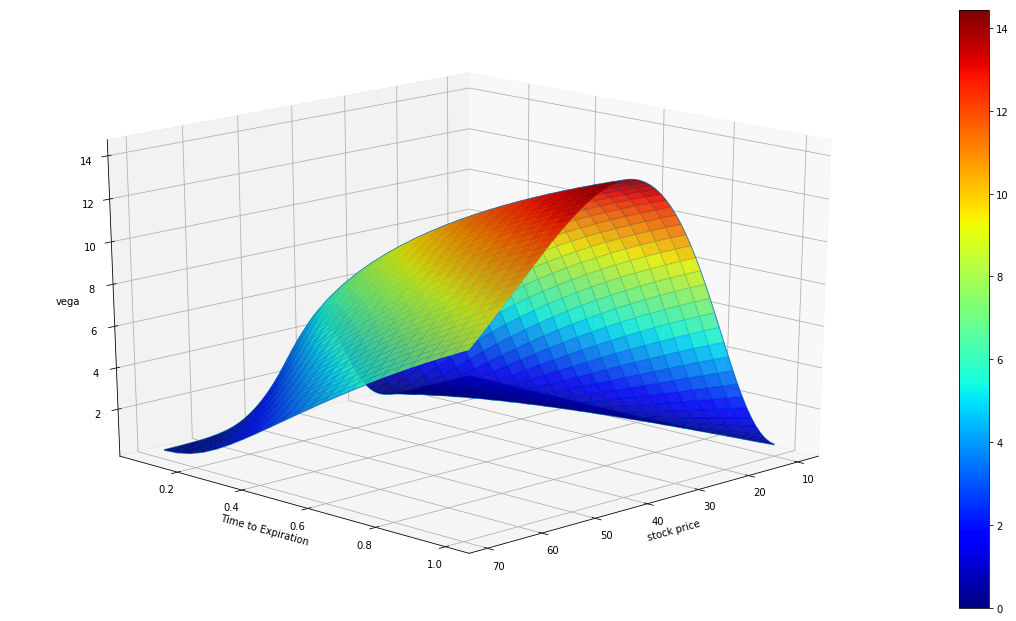

In [24]:
z = vega
norm = matplotlib.colors.Normalize() 
fig = plt.figure(figsize=(20,11))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(20,45)
ax.plot_wireframe(s, T, z, rstride=1, cstride=1)
ax.plot_surface(s, T, z, facecolors=cm.jet(norm(z)),linewidth=0.001, rstride=1, cstride=1, alpha = 0.9)
ax.set_zlim3d(z.min(), z.max())
ax.set_xlabel('stock price')
ax.set_ylabel('Time to Expiration')
ax.set_zlabel('vega')
m = cm.ScalarMappable(cmap=cm.jet)
m.set_array(z)
cbar = plt.colorbar(m)